In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
# Numpy, Pandas, and tqdm
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm

# Open Bandit Pipeline 
from obp.dataset import SyntheticBanditDatasetWithActionEmbeds
from policy import gen_eps_greedy
from ope import run_ope
from plots import plot_line

# Configuration
import conf

# Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
reward_std_list = conf.reward_std_list
x = "reward_std"
xlabel = r"noise level of the reward $\sigma$"
xticklabels = conf.reward_std_list

result_df_list = []
for reward_std in reward_std_list:

    estimated_policy_value_list = []

    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=conf.n_actions,
        dim_context=conf.dim_context,
        beta=conf.beta,
        reward_type=conf.reward_type,
        n_cat_per_dim=conf.n_cat_per_dim, 
        latent_param_mat_dim=conf.latent_param_mat_dim, 
        n_cat_dim=conf.n_cat_dim,
        n_unobserved_cat_dim=conf.n_unobserved_cat_dim,
        n_deficient_actions=conf.n_deficient_actions,
        reward_function=conf.reward_function,
        reward_std=reward_std,
        random_state=conf.random_state,
    )
    
    ### test bandit data is used to approximate the ground-truth policy value
    test_bandit_data = dataset.obtain_batch_bandit_feedback(
        n_rounds=conf.n_test
        )

    # Generate an evaluation policy via the epsilon-greedy rule
    action_dist_test = gen_eps_greedy(
        expected_reward=test_bandit_data["expected_reward"],
        is_optimal=conf.is_optimal,
        eps=conf.eps,
    )

    # actulal policy value e.g., 0.26909277388815384
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_bandit_data["expected_reward"],
        action_dist=action_dist_test,
    )
    
    for _ in tqdm(range(conf.n_seeds), desc = f"{xlabel}: {reward_std}"):
        ## generate validation data
        val_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=conf.n_train
            )

        ## make decisions on validation data
        action_dist_val = gen_eps_greedy(
            expected_reward=val_bandit_data["expected_reward"],
            is_optimal=conf.is_optimal,
            eps=conf.eps,
        )
        
        # get the estimated values of several estimators e.g., DM, IPS, DR, MIPS
        estimated_policy_values = run_ope(
            dataset=dataset, 
            round = _, 
            # observed data D
            val_bandit_data=val_bandit_data,
            # evaluation policy \pi(a|x)
            action_dist_val=action_dist_val,
            embed_selection=conf.embed_selection,
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    
    
    ## summarize results
    result_df = (
        DataFrame(DataFrame(estimated_policy_value_list).stack())
        .reset_index(1)
        .rename(columns={"level_1": "est", 0: "value"})
    )
    result_df[x] = reward_std
    result_df["se"] = (result_df.value - policy_value) ** 2
    result_df["bias"] = 0
    result_df["variance"] = 0
    sample_mean = DataFrame(result_df.groupby(["est"]).mean().value).reset_index()
    for est_ in sample_mean["est"]:
        estimates = result_df.loc[result_df["est"] == est_, "value"].values
        mean_estimates = sample_mean.loc[sample_mean["est"] == est_, "value"].values
        mean_estimates = np.ones_like(estimates) * mean_estimates
        result_df.loc[result_df["est"] == est_, "bias"] = (
            policy_value - mean_estimates
        ) ** 2
        result_df.loc[result_df["est"] == est_, "variance"] = (
            estimates - mean_estimates
        ) ** 2
    result_df_list.append(result_df)


# aggregate all results
result_df = pd.concat(result_df_list).reset_index(level=0)

noise level of the reward $\sigma$: 3: 100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


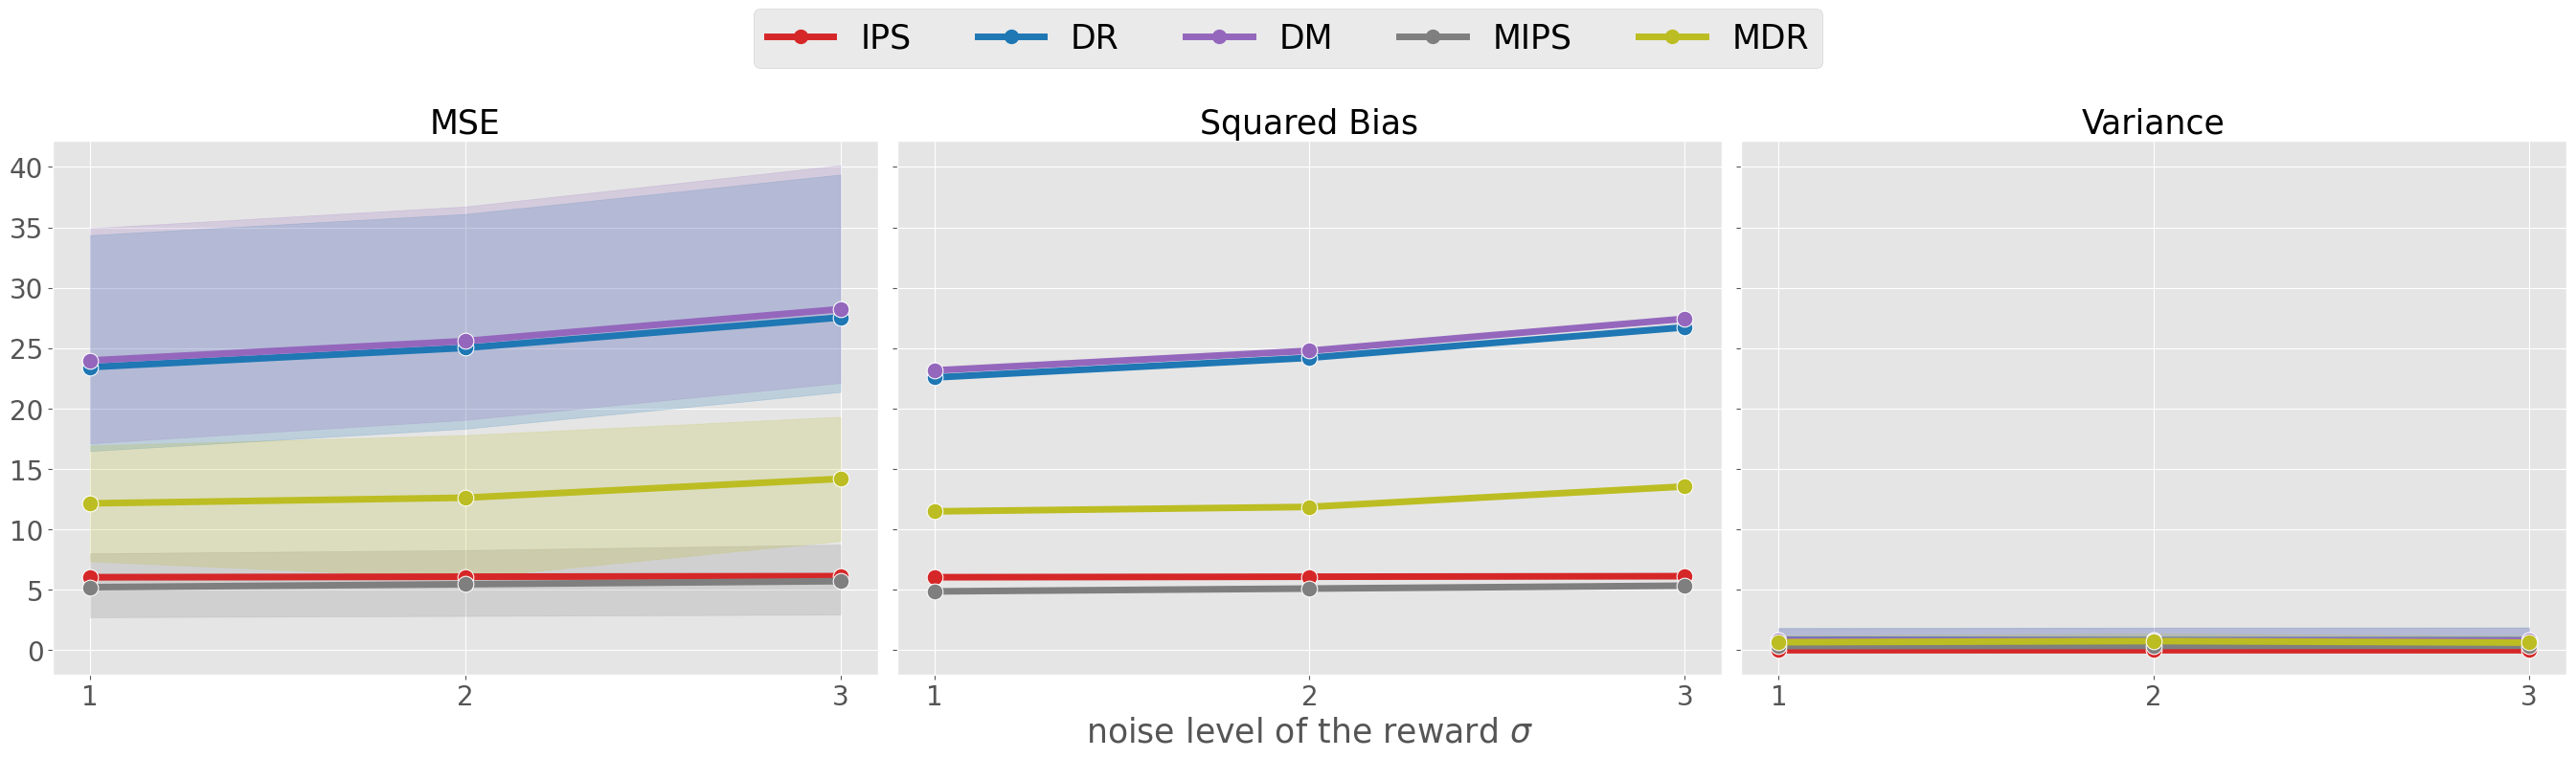

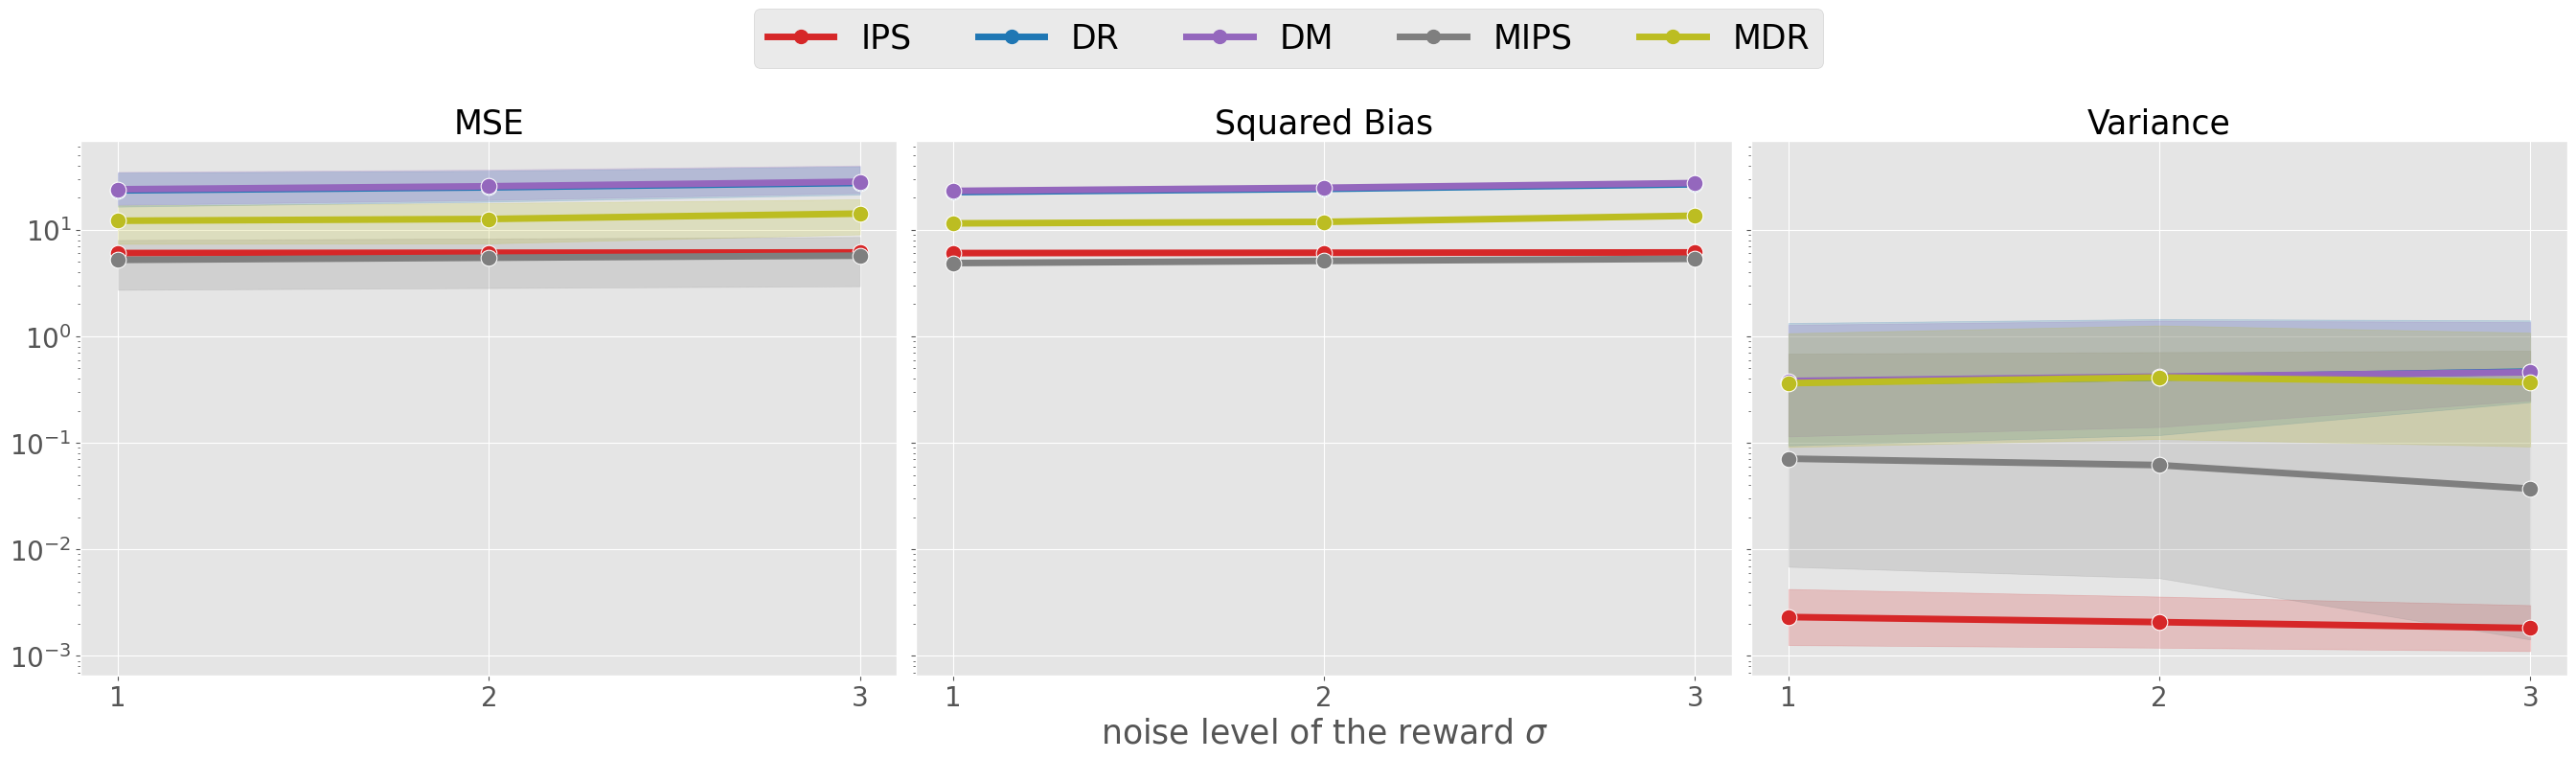

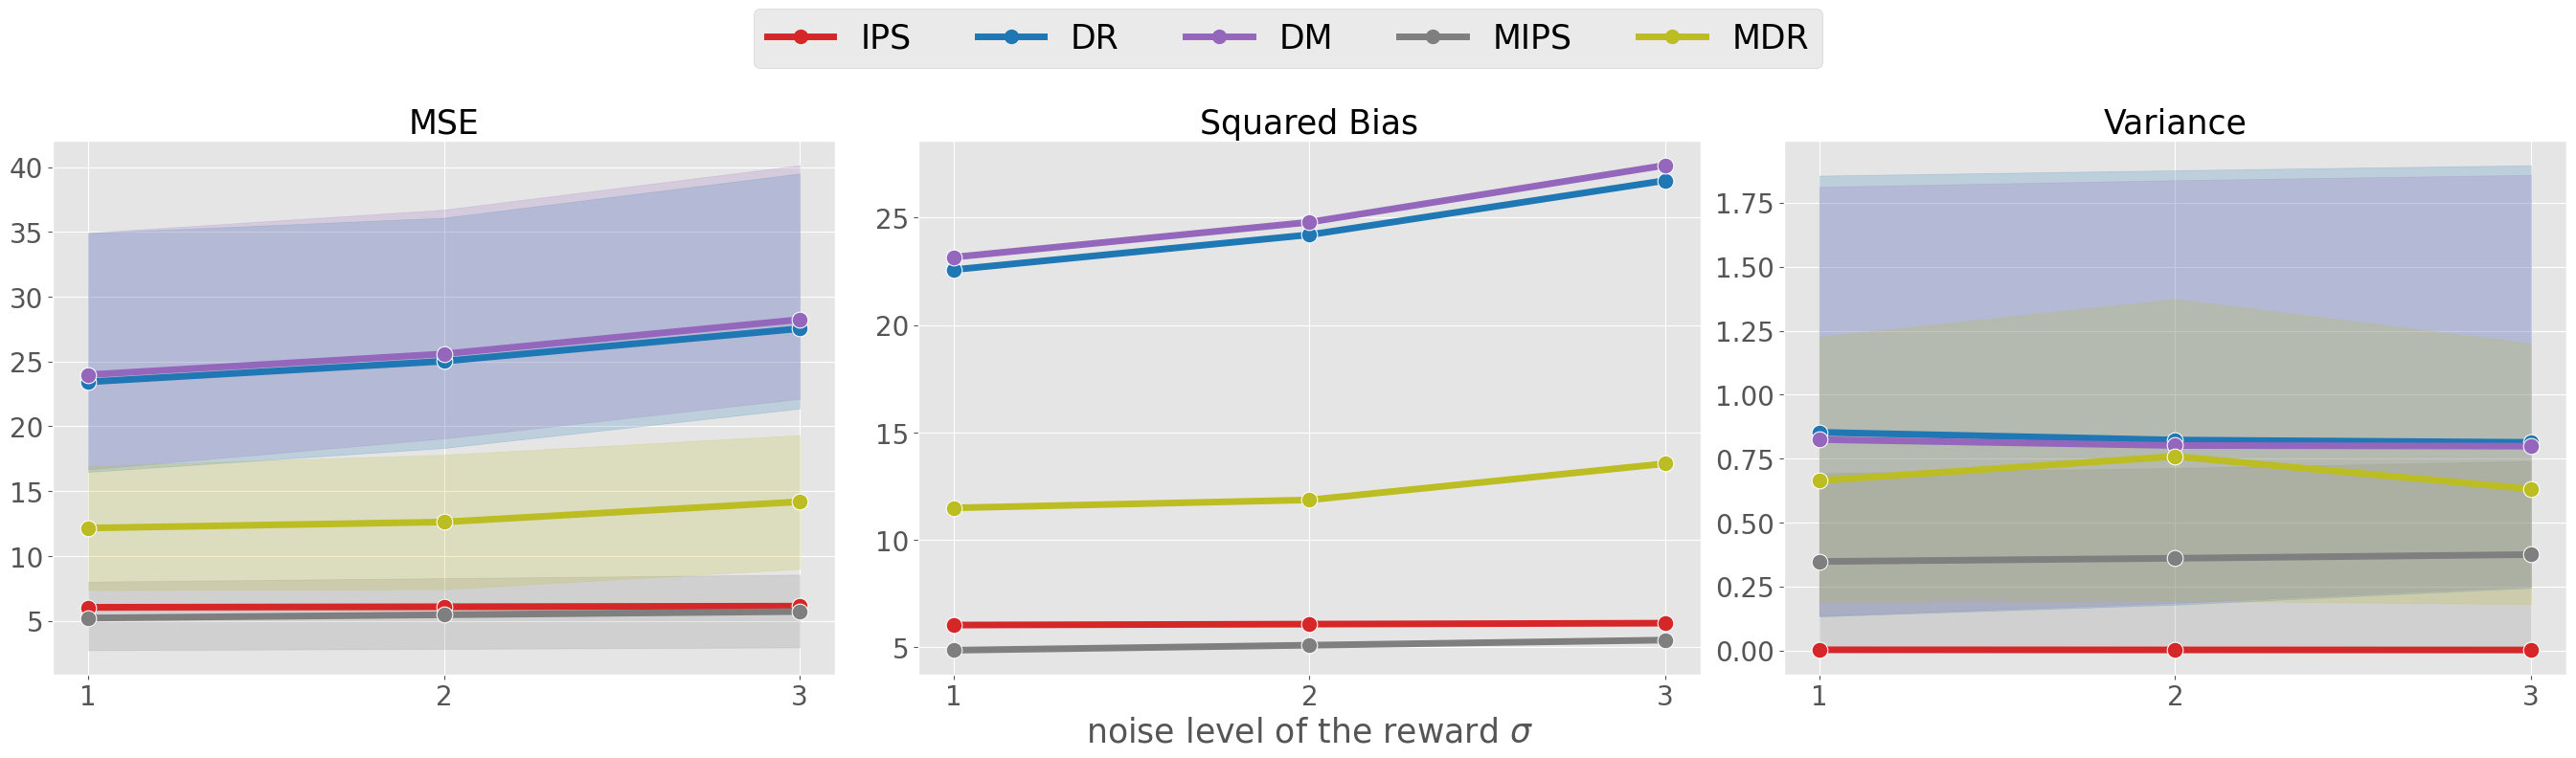

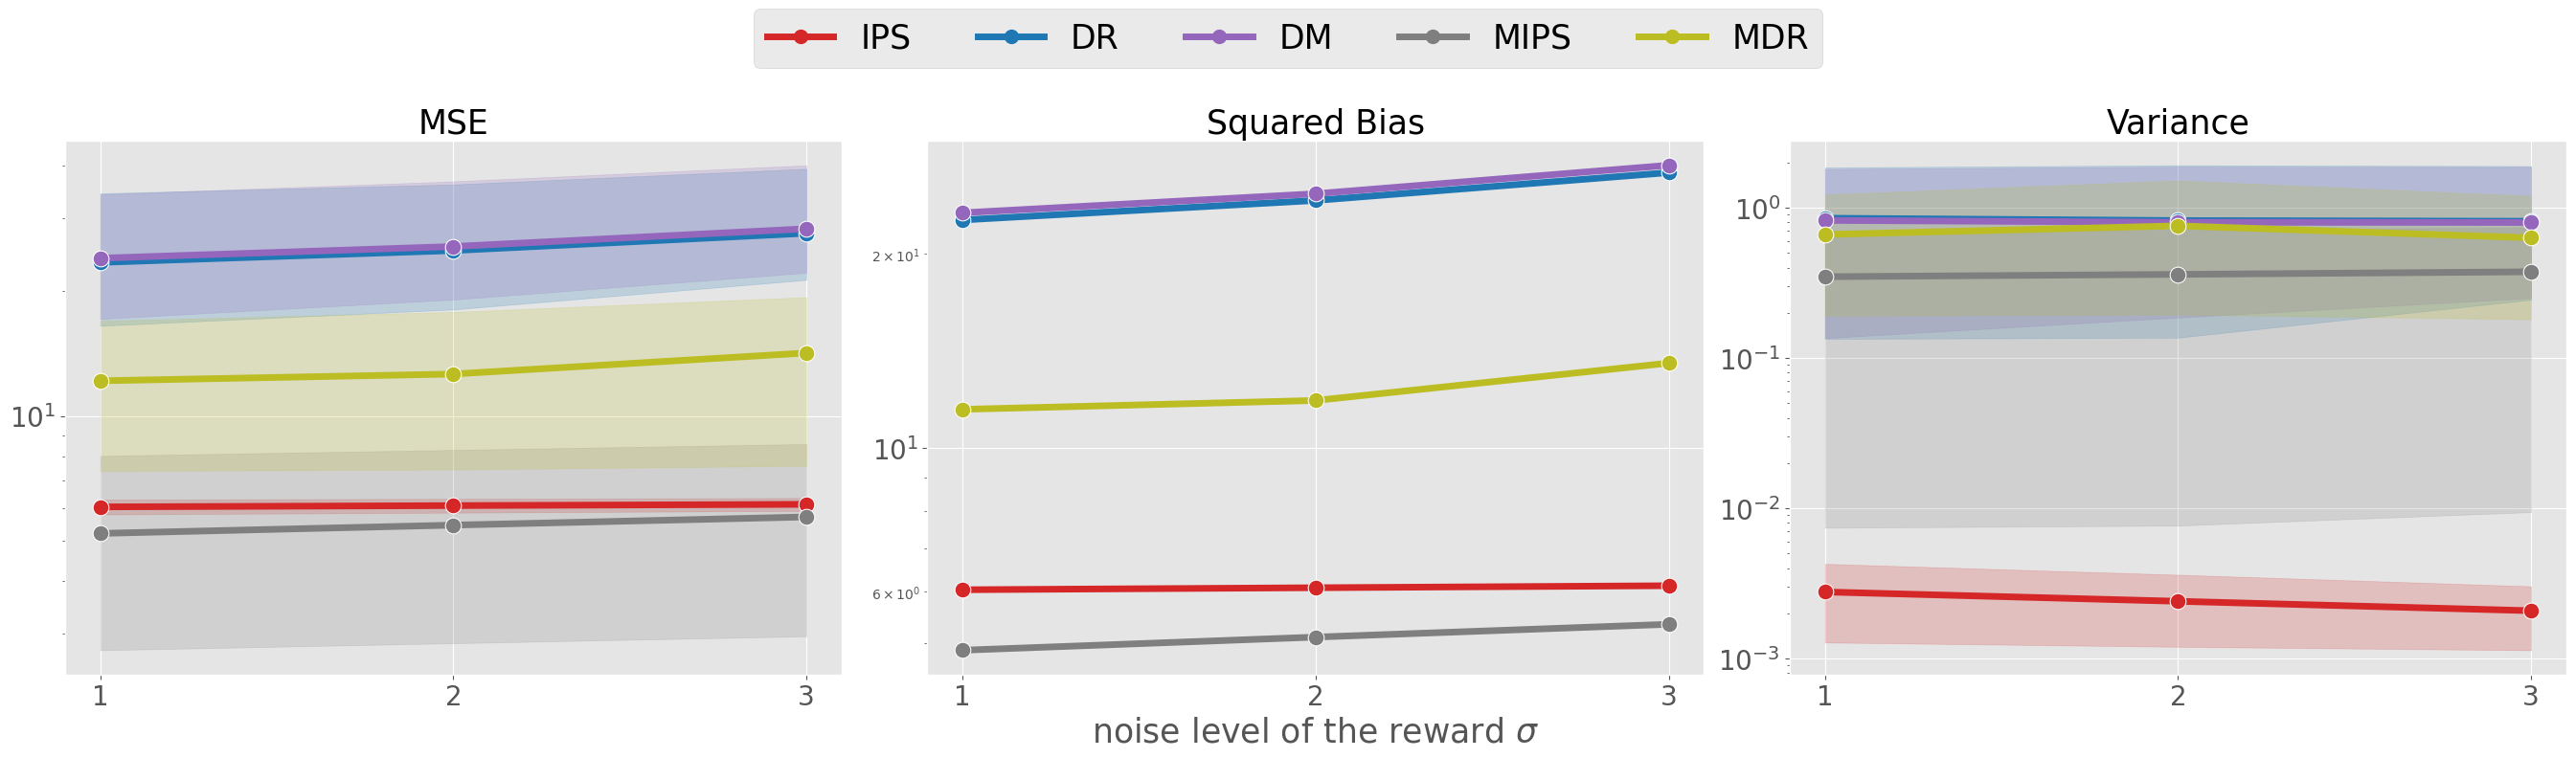

In [8]:
for flag_share_y_scale in [True, False]:
    for flag_log_scale in [False, True]:
        plot_line(
            result_df = result_df, 
            x = x, 
            xlabel = xlabel, 
            xticklabels = xticklabels, 
            flag_log_scale=flag_log_scale, 
            flag_share_y_scale=flag_share_y_scale,
        )